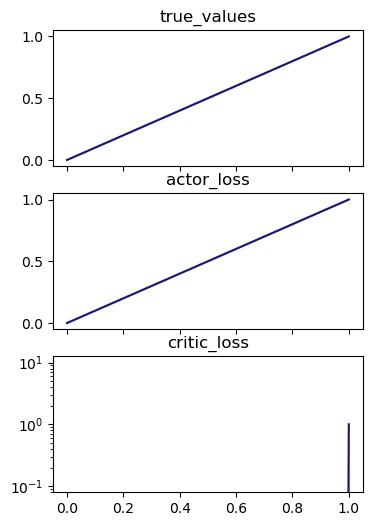

In [5]:
from trainer.trainer import treeTrainer
from agent.agent import normalDistAgent
from env.env import treeEnvB
import env.propagatorB as pB

# propB = pB.CWPropagatorB(device="cuda")
propB = pB.CWDebrisPropagatorB(device="cuda", n_debris=1)

pop = 512
max_gen = 3600
action_bound = 6e-2
env = treeEnvB.from_propagator(propB, population=pop, max_gen=max_gen, device="cuda")
agent = normalDistAgent(obs_dim=propB.obs_dim, action_dim=propB.action_dim,
    actor_hiddens=[512]*10, critic_hiddens=[512]*10, 
    action_lower_bound=-action_bound, action_upper_bound=action_bound, 
    actor_lr=1E-5, critic_lr=5E-4)
T = treeTrainer(env, agent, gamma=0.99)
# T.agent.load("../model/check_point9.ptd")

In [ ]:
T.agent.load("../model/seq.ptd")

In [6]:
import rich.progress
import matplotlib.pyplot as plt
n = 1000
batch_size = 64
horizon = 3600
loss_list = []
with rich.progress.Progress() as pbar:
    task = pbar.add_task("sequential optimize", total=n)
    for _ in range(n):
        states = T.propagator.T.randomInitStates(batch_size).to(agent.device)
        loss = T.propagator.seqOpt(states, agent, horizon)
        loss_list.append(loss.item())
        pbar.update(task, advance=1)
T.agent.save("../model/seq.ptd")
plt.close("all")
plt.plot(loss_list)
plt.show()

Output()

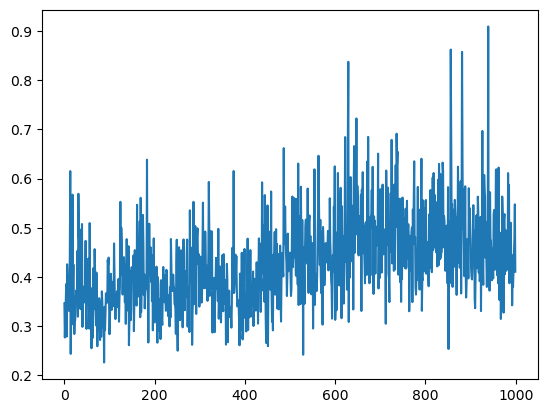

In [ ]:
T.agent.save("../model/seq.ptd")
plt.close("all")
plt.plot(loss_list)
plt.show()

In [ ]:
T.train(n_epoch=10)

In [ ]:
from plotting.dataplot import dataPlot
_ = dataPlot.from_log("../model/log.npz")

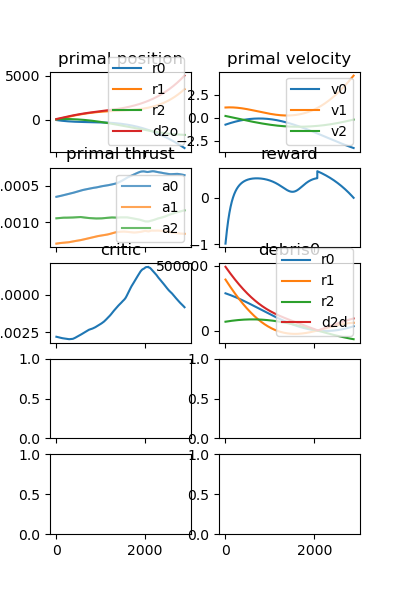

In [ ]:
from plotting.analyze import *
%matplotlib widget
plt.close('all')
_, d = T.test(decide_mode="determined", t_max=.01, g_max=3)
fig, _ = historyFile(d, T.agent, stage=T.testEnv.stage, n_debris=T.propagator.N.n_debris)

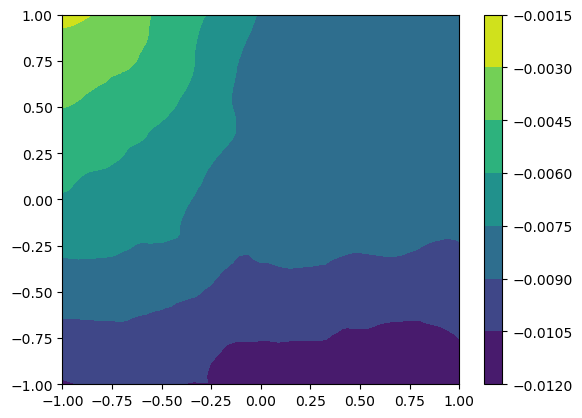

In [ ]:
from plotting.analyze import *
bound = 1
span = [-bound, bound]
criticContour(T.agent, dims=(0,1), span=span, step=201)

In [ ]:
from trainer.example import CWTreeTrainer
from trainer.mpTrainer import mpTreeTrainer

args = {
    "population": 512,
    "batch_size": 2048
}

mpt = mpTreeTrainer(8, trainerType=CWTreeTrainer)
mpt.main_agent.load("../model/check_point9.ptd")
T = mpt.main_trainer

In [ ]:
mpt.train(10, 100, folder="../model/")